In [1]:
import torch
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import json
import time
import sys

from scarches.dataset.trvae.data_handling import remove_sparsity
from lataq.models import EMBEDCVAE

%load_ext autoreload
%autoreload 2

Global seed set to 0


In [2]:
PARAMS = {
    'EARLY_STOPPING_KWARGS': {                         #KWARGS FOR EARLY STOPPING
        "early_stopping_metric": "val_landmark_loss",  ####value used for early stopping
        "mode": "min",                                 ####choose if look for min or max
        "threshold": 0,
        "patience": 20,
        "reduce_lr": True,
        "lr_patience": 13,
        "lr_factor": 0.1,
    },
}

In [42]:
covariate_key = 'sample'
print(f'Lataq model {covariate_key} as batch integration covariate')
print('load data')
condition_key = covariate_key
cell_type_key = ['predicted.celltype.l1']
adata = sc.read(
    '../../data/su_2020_rna.h5ad'
)

Lataq model sample as batch integration covariate
load data


In [43]:
fred_full_meta = pd.read_csv('/lustre/groups/ml01/workspace/hediyehzadeh.s/shared_data/multigrate_multimil/notebooks/covid19_datasets_metadata_fredhutch.csv', index_col = 0)

datasetkey = 'su_2020'
fred_meta = fred_full_meta[fred_full_meta.dataset == datasetkey]

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (4,5,7,8,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [44]:
adata.obs = fred_meta

In [6]:
#adata = adata[adata.obs[f'{cell_type_key[0]}'] != 'other']

In [7]:
#from sklearn.model_selection import KFold
#cv = KFold(n_splits=5, shuffle=True, random_state=42)
#
#i = 0
#for train_samples, _ in cv.split(adata.obs['sample'].unique()):
#    if i == 2:
#        sample_ref = train_samples
#    i += 1
#    
#sample_ref = adata.obs['sample'].unique()[sample_ref]

In [45]:
np.random.seed(42)
sample_ref = np.random.choice(adata.obs['sample'].unique(), 240, replace=False)

In [46]:
labeled_idx = np.where(adata.obs['sample'].isin(sample_ref))[0]

In [47]:
adata_tmp = adata.copy()
sc.pp.normalize_total(adata_tmp)
sc.pp.log1p(adata_tmp)
sc.pp.highly_variable_genes(
    adata_tmp, n_top_genes=2000, flavor="seurat_v3", subset=False
)
adata = adata[:, adata_tmp.var['highly_variable']]

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [66]:
query_adata = adata[~adata.obs['sample'].isin(sample_ref)]
ref_adata = adata[adata.obs['sample'].isin(sample_ref)]

In [49]:
EMBEDCVAE?

Init signature:
EMBEDCVAE(
    adata: anndata._core.anndata.AnnData,
    condition_key: str = None,
    conditions: Union[list, NoneType] = None,
    cell_type_keys: Union[list, NoneType] = None,
    cell_types: Union[dict, NoneType] = None,
    unknown_ct_names: Union[list, NoneType] = None,
    labeled_indices: Union[list, NoneType] = None,
    landmarks_labeled: Union[dict, NoneType] = None,
    landmarks_unlabeled: Union[dict, NoneType] = None,
    hidden_layer_sizes: list = [256, 64],
    latent_dim: int = 10,
    dr_rate: float = 0.05,
    use_mmd: bool = False,
    mmd_on: str = 'z',
    mmd_boundary: Union[int, NoneType] = None,
    recon_loss: Union[str, NoneType] = 'nb',
    beta: float = 1,
    use_bn: bool = False,
    use_ln: bool = True,
    inject_condition: list = ['decoder'],
    embedding_dim: int = 10,
)
Docstring:     
Model for EmbedCVAE, inherits LATAQ.

Parameters
----------
inject_condition
File:           /lustre/groups/ml01/workspace/carlo.dedonno/LATAQ/lataq/

In [50]:
lataq_model = EMBEDCVAE(
    adata=adata,
    condition_key=condition_key,
    cell_type_keys=cell_type_key,
    labeled_indices=labeled_idx,
    unknown_ct_names=['other'],
    hidden_layer_sizes=[128]*3,
    latent_dim=30,
    embedding_dim=20,
    inject_condition=['encoder', 'decoder']
)


Embedding dictionary:
 	Num conditions: 270
 	Embedding dim: 20
Encoder Architecture:
	Input Layer in, out and cond: 2000 128 20
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Mean/Var Layer in/out: 128 30
Decoder Architecture:
	First Layer in, out and cond:  30 128 20
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Output Layer in/out:  128 2000 



In [51]:
lataq_model.train(
    n_epochs=50,
    pretraining_epochs=45,
    early_stopping_kwargs=PARAMS['EARLY_STOPPING_KWARGS'],
    alpha_epoch_anneal=1e3,
    eta=1,
    clustering_res=2,
    weight_decay=0,
    unlabeled_weight=0,
    use_stratified_sampling=False,
    best_reload=False,
)

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/scarches/trainers/trvae/_utils.py:164: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['trvae_size_factors'] = size_factors
/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/contextlib.py:120: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


loaders init
loaders init done
0.0012421607971191406
 |██████████████████--| 90.0%  - val_loss: 237.9982835256 - val_trvae_loss: 237.99828352560
 |████████████████████| 100.0%  - val_loss: 244.5266501370 - val_trvae_loss: 242.9526717304 - val_landmark_loss: 1.5739783647 - val_unlabeled_loss: 0.0000000000 - val_labeled_loss: 1.5739783647
Saving best state of network...
Best State was in Epoch 49


In [52]:
lataq_model.save('final_integration', overwrite=True)

In [53]:
results_dict_q = lataq_model.classify(
    x=query_adata.X.A.astype('float32'), 
    c=query_adata.obs[condition_key].values,
    metric="dist",
    get_prob=False,
    threshold=-np.inf
)

preds_q = results_dict_q[cell_type_key[0]]['preds']
probs_q = results_dict_q[cell_type_key[0]]['probs']

In [54]:
classification_df = pd.DataFrame(
    classification_report(
        y_true=query_adata.obs[cell_type_key[0]], y_pred=preds_q, output_dict=True
    )
).transpose()

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [55]:
classification_df

precision    recall  f1-score       support
B              0.984134  1.000000  0.992003   2357.000000
CD4 T          0.922352  0.900894  0.911496  18354.000000
CD8 T          0.815629  0.914105  0.862064   9500.000000
DC             0.838248  1.000000  0.912008    938.000000
Mono           0.995549  0.987365  0.991440  13138.000000
NK             0.965263  0.949895  0.957517   4271.000000
other          0.000000  0.000000  0.000000   1449.000000
other T        0.527088  0.860037  0.653604   1086.000000
accuracy       0.909655  0.909655  0.909655      0.909655
macro avg      0.756033  0.826537  0.785017  51093.000000
weighted avg   0.891664  0.909655  0.899100  51093.000000

In [70]:
lataq_model.model.eval()
adata_emb = sc.AnnData(X=lataq_model.model.embedding.weight.detach().cpu().numpy())

In [71]:
adata_emb.obs = adata.obs.groupby('sample').first().reindex(lataq_model.model.conditions)
adata_emb.obs['batch'] = '0'
adata_emb.obs['batch'][~adata_emb.obs.index.isin(sample_ref)] = '1'
adata_emb.obs.disease_severity = adata_emb.obs.disease_severity.astype('string')
adata_emb.obs.disease_severity[adata_emb.obs.disease_severity.isna()] = 'healthy'
adata_emb.obs.disease_severity = adata_emb.obs.disease_severity.astype('category')

<ipython-input-71-ac8a30f501f5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_emb.obs['batch'][~adata_emb.obs.index.isin(sample_ref)] = '1'


In [72]:
adata_emb.obs.groupby('disease_severity').size()

disease_severity
healthy      16
mild        110
moderate     92
severe       52
dtype: int64

In [73]:
adata_emb.obs.groupby('disease_severity')['batch'].value_counts()

disease_severity  batch
healthy           0        15
                  1         1
mild              0        95
                  1        15
moderate          0        82
                  1        10
severe            0        48
                  1         4
Name: batch, dtype: int64

In [74]:
sc.pp.pca(adata_emb)


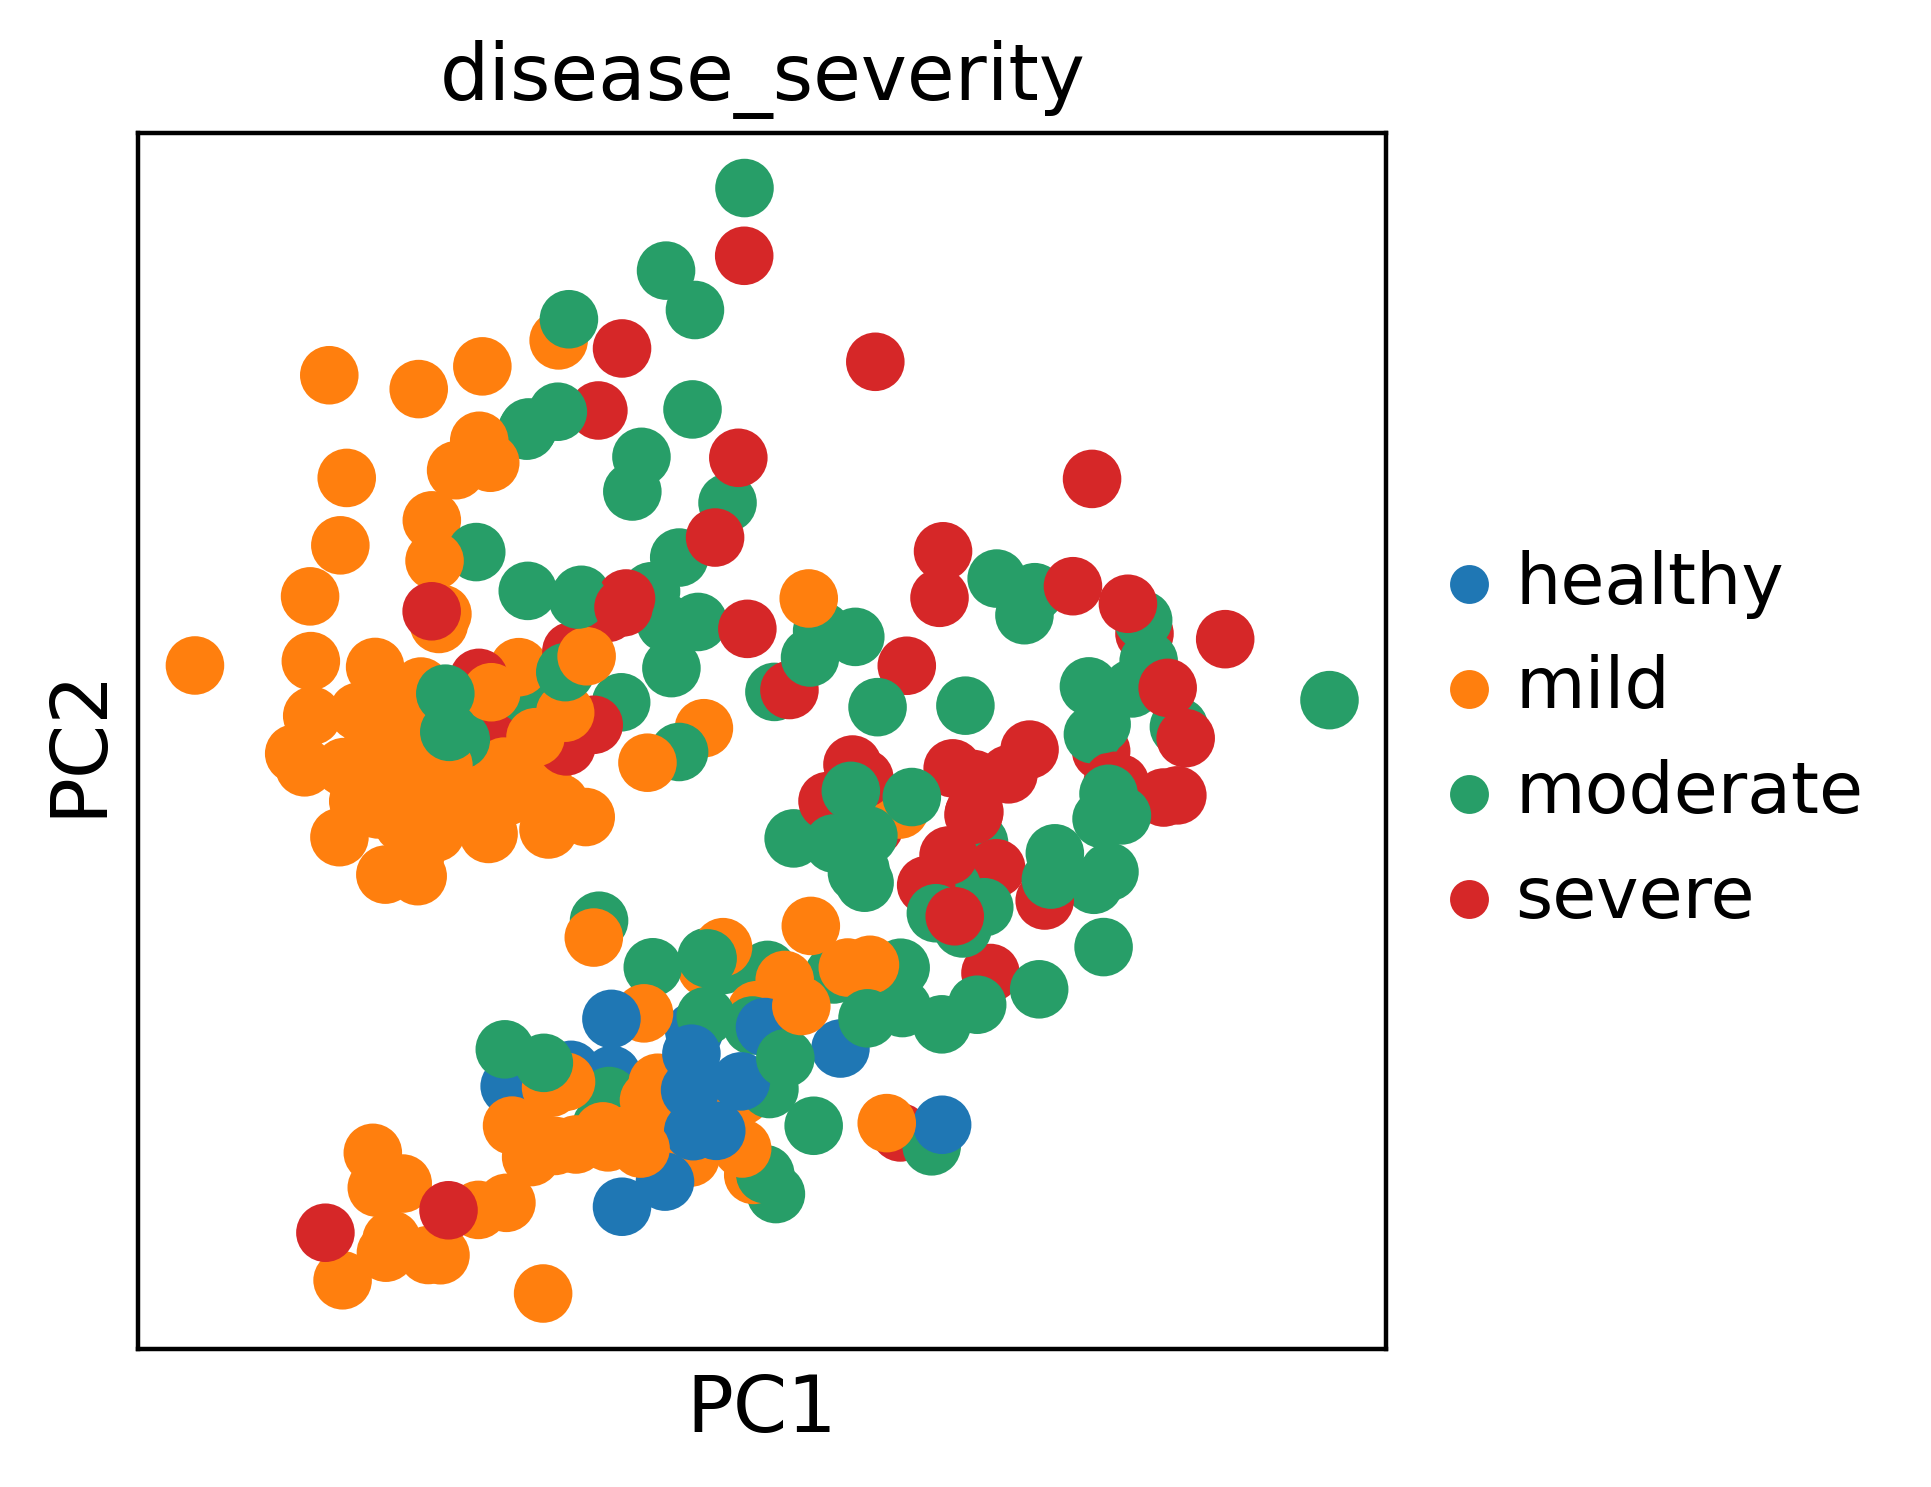

In [75]:
sc.pl.pca(adata_emb, color='disease_severity')

In [76]:
adata_emb.obs['disease_clf'] = adata_emb.obs['disease_severity'].astype('string')
adata_emb.obs['disease_clf'][adata_emb.obs['disease_clf'].isin(['healthy', 'mild'])] = 'healthy'
adata_emb.obs['disease_clf'][~adata_emb.obs['disease_clf'].isin(['healthy', 'mild'])] = 'covid'                             
adata_emb.obs['disease_clf'] = adata_emb.obs['disease_clf'].astype('category')

In [77]:
X_train = adata_emb.obsm['X_pca'][adata_emb.obs['batch']=='0']
X_test = adata_emb.obsm['X_pca'][adata_emb.obs['batch']=='1']

y_train = adata_emb.obs['disease_severity'][adata_emb.obs['batch']=='0'].values
y_test = adata_emb.obs['disease_severity'][adata_emb.obs['batch']=='1'].values


In [78]:
from sklearn.neighbors import KNeighborsClassifier


In [79]:
clf = KNeighborsClassifier(n_neighbors=4).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=clf.classes_))

              precision    recall  f1-score   support

     healthy       0.00      0.00      0.00         1
        mild       0.82      0.93      0.87        15
    moderate       0.67      0.80      0.73        10
      severe       0.00      0.00      0.00         4

    accuracy                           0.73        30
   macro avg       0.37      0.43      0.40        30
weighted avg       0.63      0.73      0.68        30



/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [80]:
results_dict_q = lataq_model.classify(
    x=query_adata.X.A, 
    c=query_adata.obs[condition_key].values,
    metric="dist",
    get_prob=False,
    threshold=-np.inf
)
preds_q = results_dict_q[cell_type_key[0]]['preds']
probs_q = results_dict_q[cell_type_key[0]]['probs']
probs_log = np.log1p(probs_q)
is_novel = probs_log < 0.05

In [82]:
lataq_model.model.eval()
adata_latent_ref = lataq_model.get_latent(
    ref_adata.X.A, 
    ref_adata.obs[condition_key].values,
    mean=True
)

adata_latent_ref = sc.AnnData(adata_latent_ref)
adata_latent_ref.obs = ref_adata.obs.copy()

adata_latent_q = lataq_model.get_latent(
    query_adata.X.A, 
    query_adata.obs[condition_key].values,
    mean=True
)


adata_latent_q = sc.AnnData(adata_latent_q)
adata_latent_q.obs = query_adata.obs.copy()


adata_latent_q.obs[f'{cell_type_key[0]}_pred'] = preds_q.tolist()
adata_latent_q.obs[f'{cell_type_key[0]}_prob'] = probs_q.tolist()
#adata_latent_q.obs['log_probs'] = probs_log
#adata_latent_q.obs[f'{cell_type_key[0]}_pred'][adata_latent_q.obs['log_probs'] > 0.06] = 'unknown'
adata_latent_q.obs[f'classifier_outcome'] = (
    adata_latent_q.obs[f'{cell_type_key[0]}_pred'] == adata_latent_q.obs[f'{cell_type_key[0]}']
)
adata_latent_q.obs['classifier_outcome'] = adata_latent_q.obs['classifier_outcome'].astype(str)
#adata_latent_q.obs['classifier_outcome'][adata_latent_q.obs[f'{cell_type_key[0]}_pred']=='unknown'] = 'Unknown'

labeled_set = lataq_model.get_landmarks_info()
labeled_set.obs['condition'] = 'labeled landmark'
adata_latent_full = adata_latent_ref.concatenate([adata_latent_q, labeled_set], batch_key='query')
print(adata_latent_full.obs.groupby(f'{cell_type_key[0]}_pred').size())
print(adata_latent_full.obs[f'{cell_type_key[0]}_pred'].unique())
adata_latent_full.obs[f'{cell_type_key[0]}_pred'][adata_latent_full.obs['query'].isin(['0'])] = 'reference'


/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


predicted.celltype.l1_pred
B           2394
CD4 T      17933
CD8 T      10656
DC          1118
Mono       13036
NK          4204
other T     1759
dtype: int64
[nan 'CD8 T' 'Mono' 'CD4 T' 'B' 'other T' 'NK' 'DC']


<ipython-input-82-88ab0ed2d8ef>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_latent_full.obs[f'{cell_type_key[0]}_pred'][adata_latent_full.obs['query'].isin(['0'])] = 'reference'


In [83]:
sc.pp.neighbors(adata_latent_full, n_neighbors=15)
sc.tl.umap(adata_latent_full)

In [84]:
for col in adata_latent_full.obs.columns:
    adata_latent_full.obs[col] = adata_latent_full.obs[col].astype(str)

In [85]:
adata_latent_full.write('integrated_final.h5ad')

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


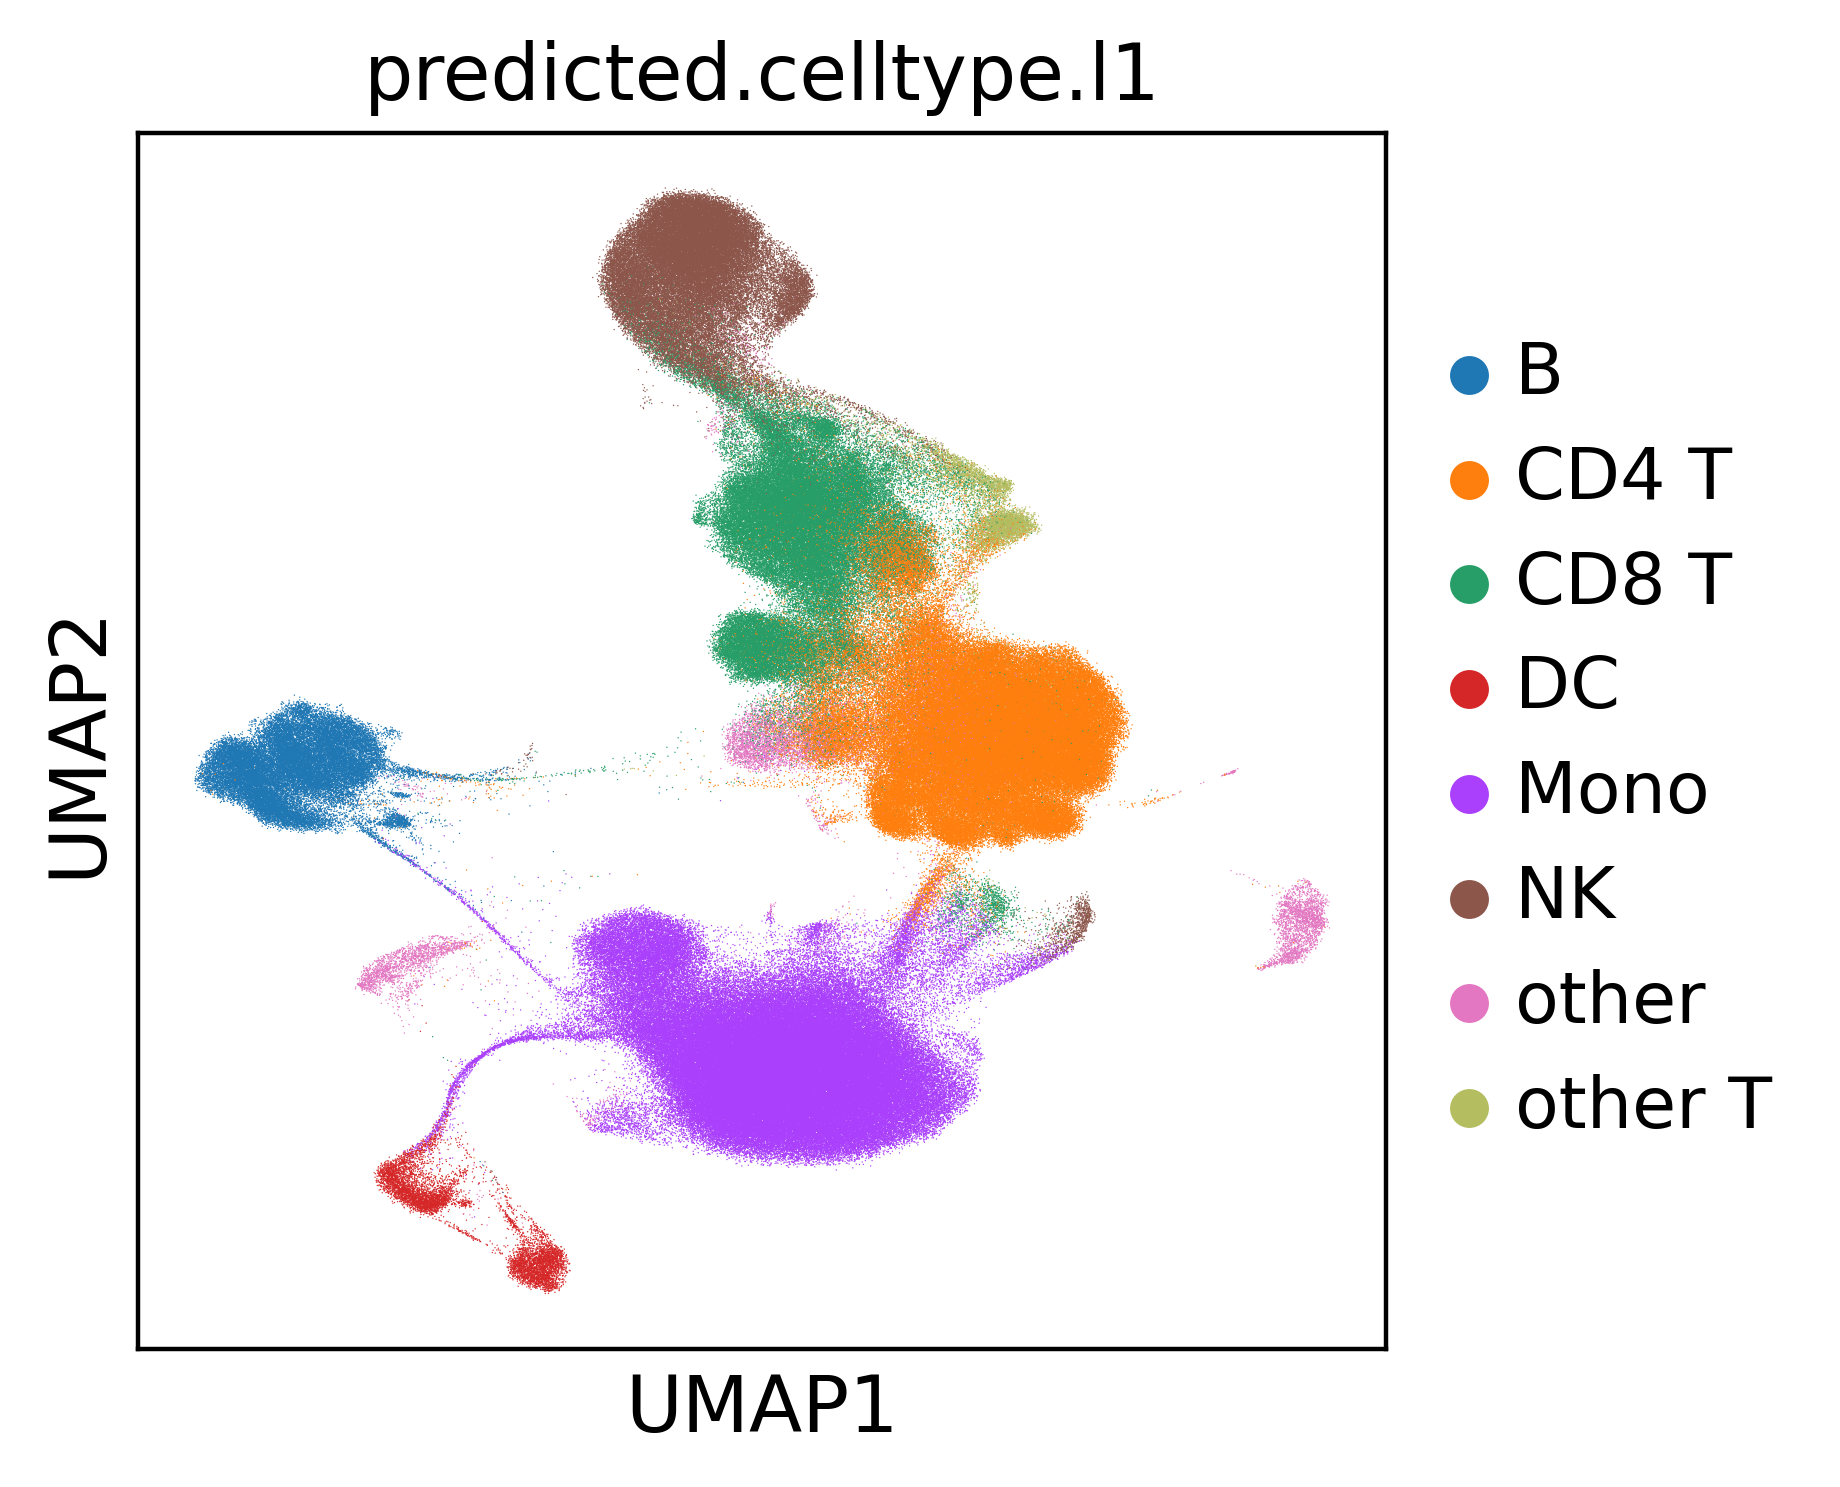

In [86]:
sc.pl.umap(adata_latent_full[adata_latent_full.obs['query']=='0'], color=f'{cell_type_key[0]}')

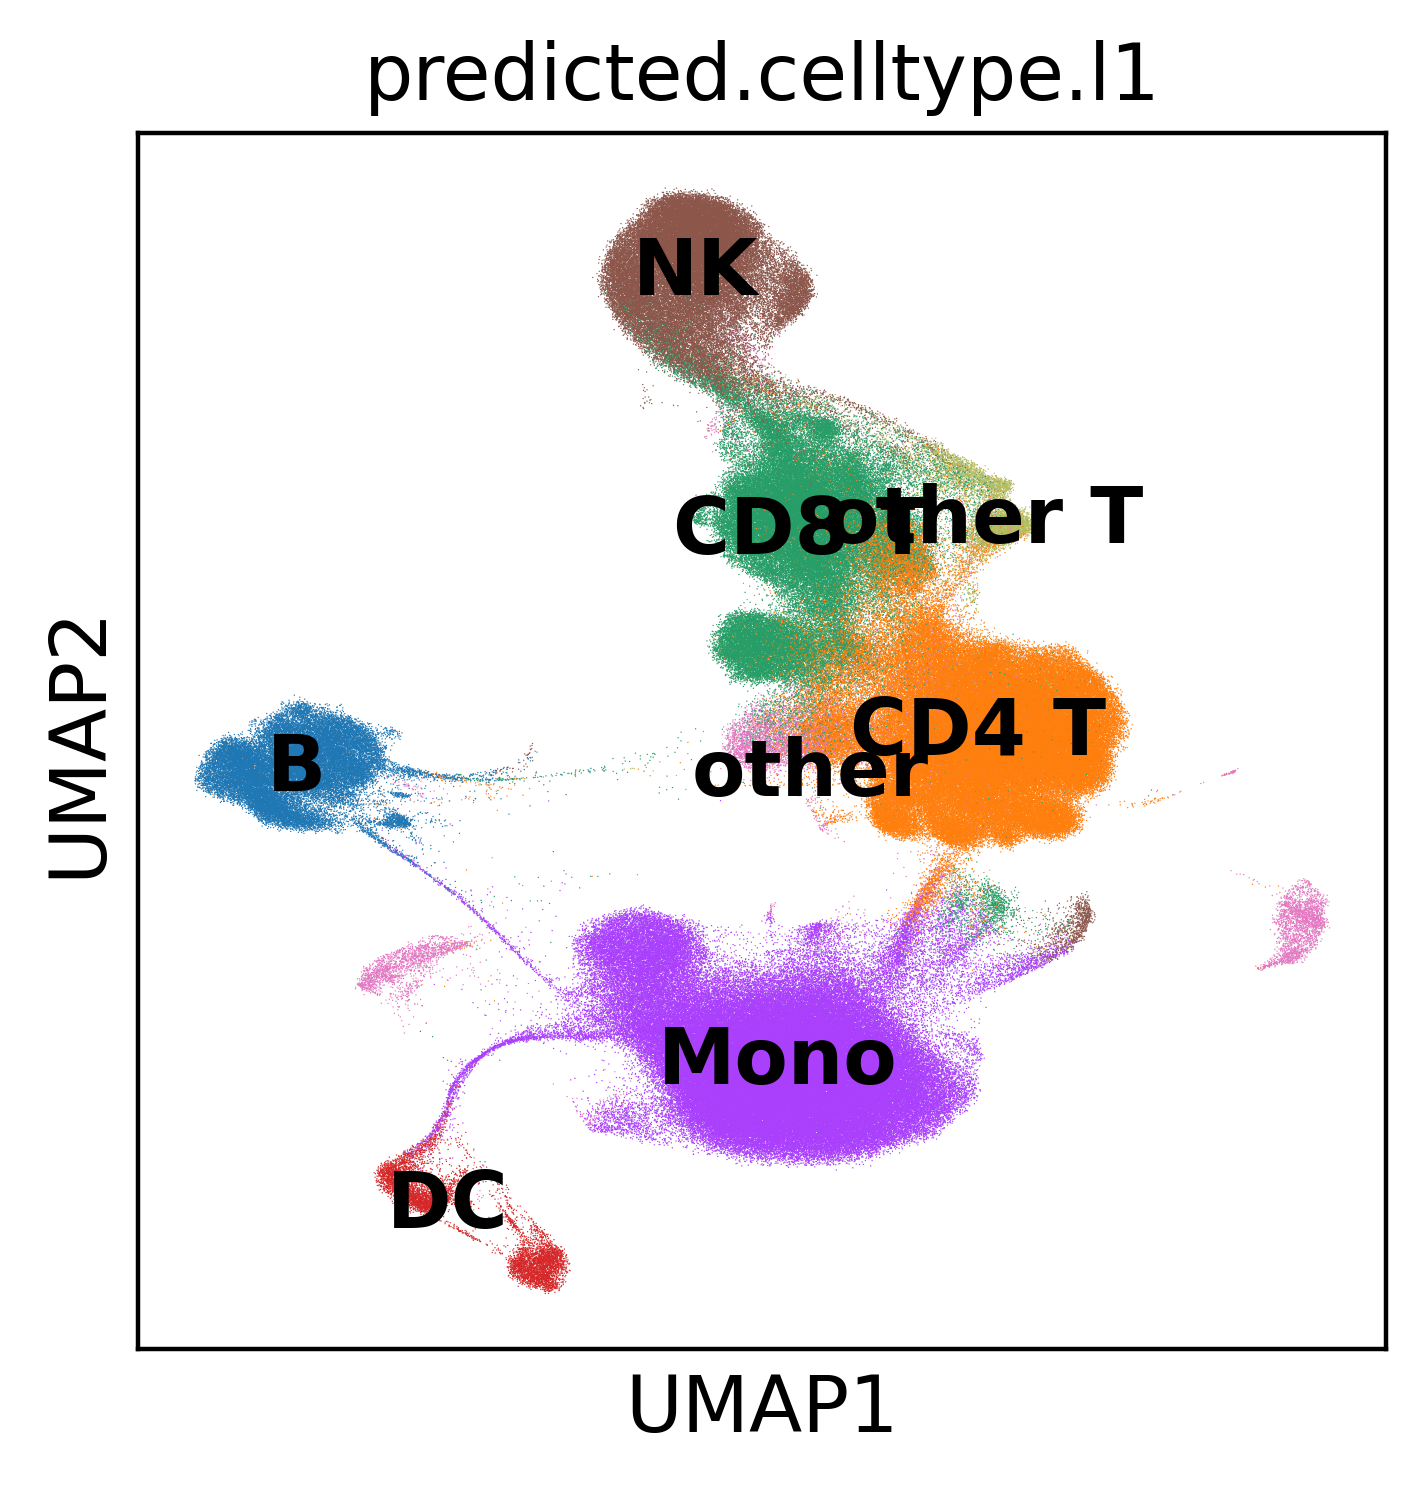

In [87]:
sc.pl.umap(adata_latent_full[adata_latent_full.obs['query']=='0'], color=f'{cell_type_key[0]}', legend_loc='on data')


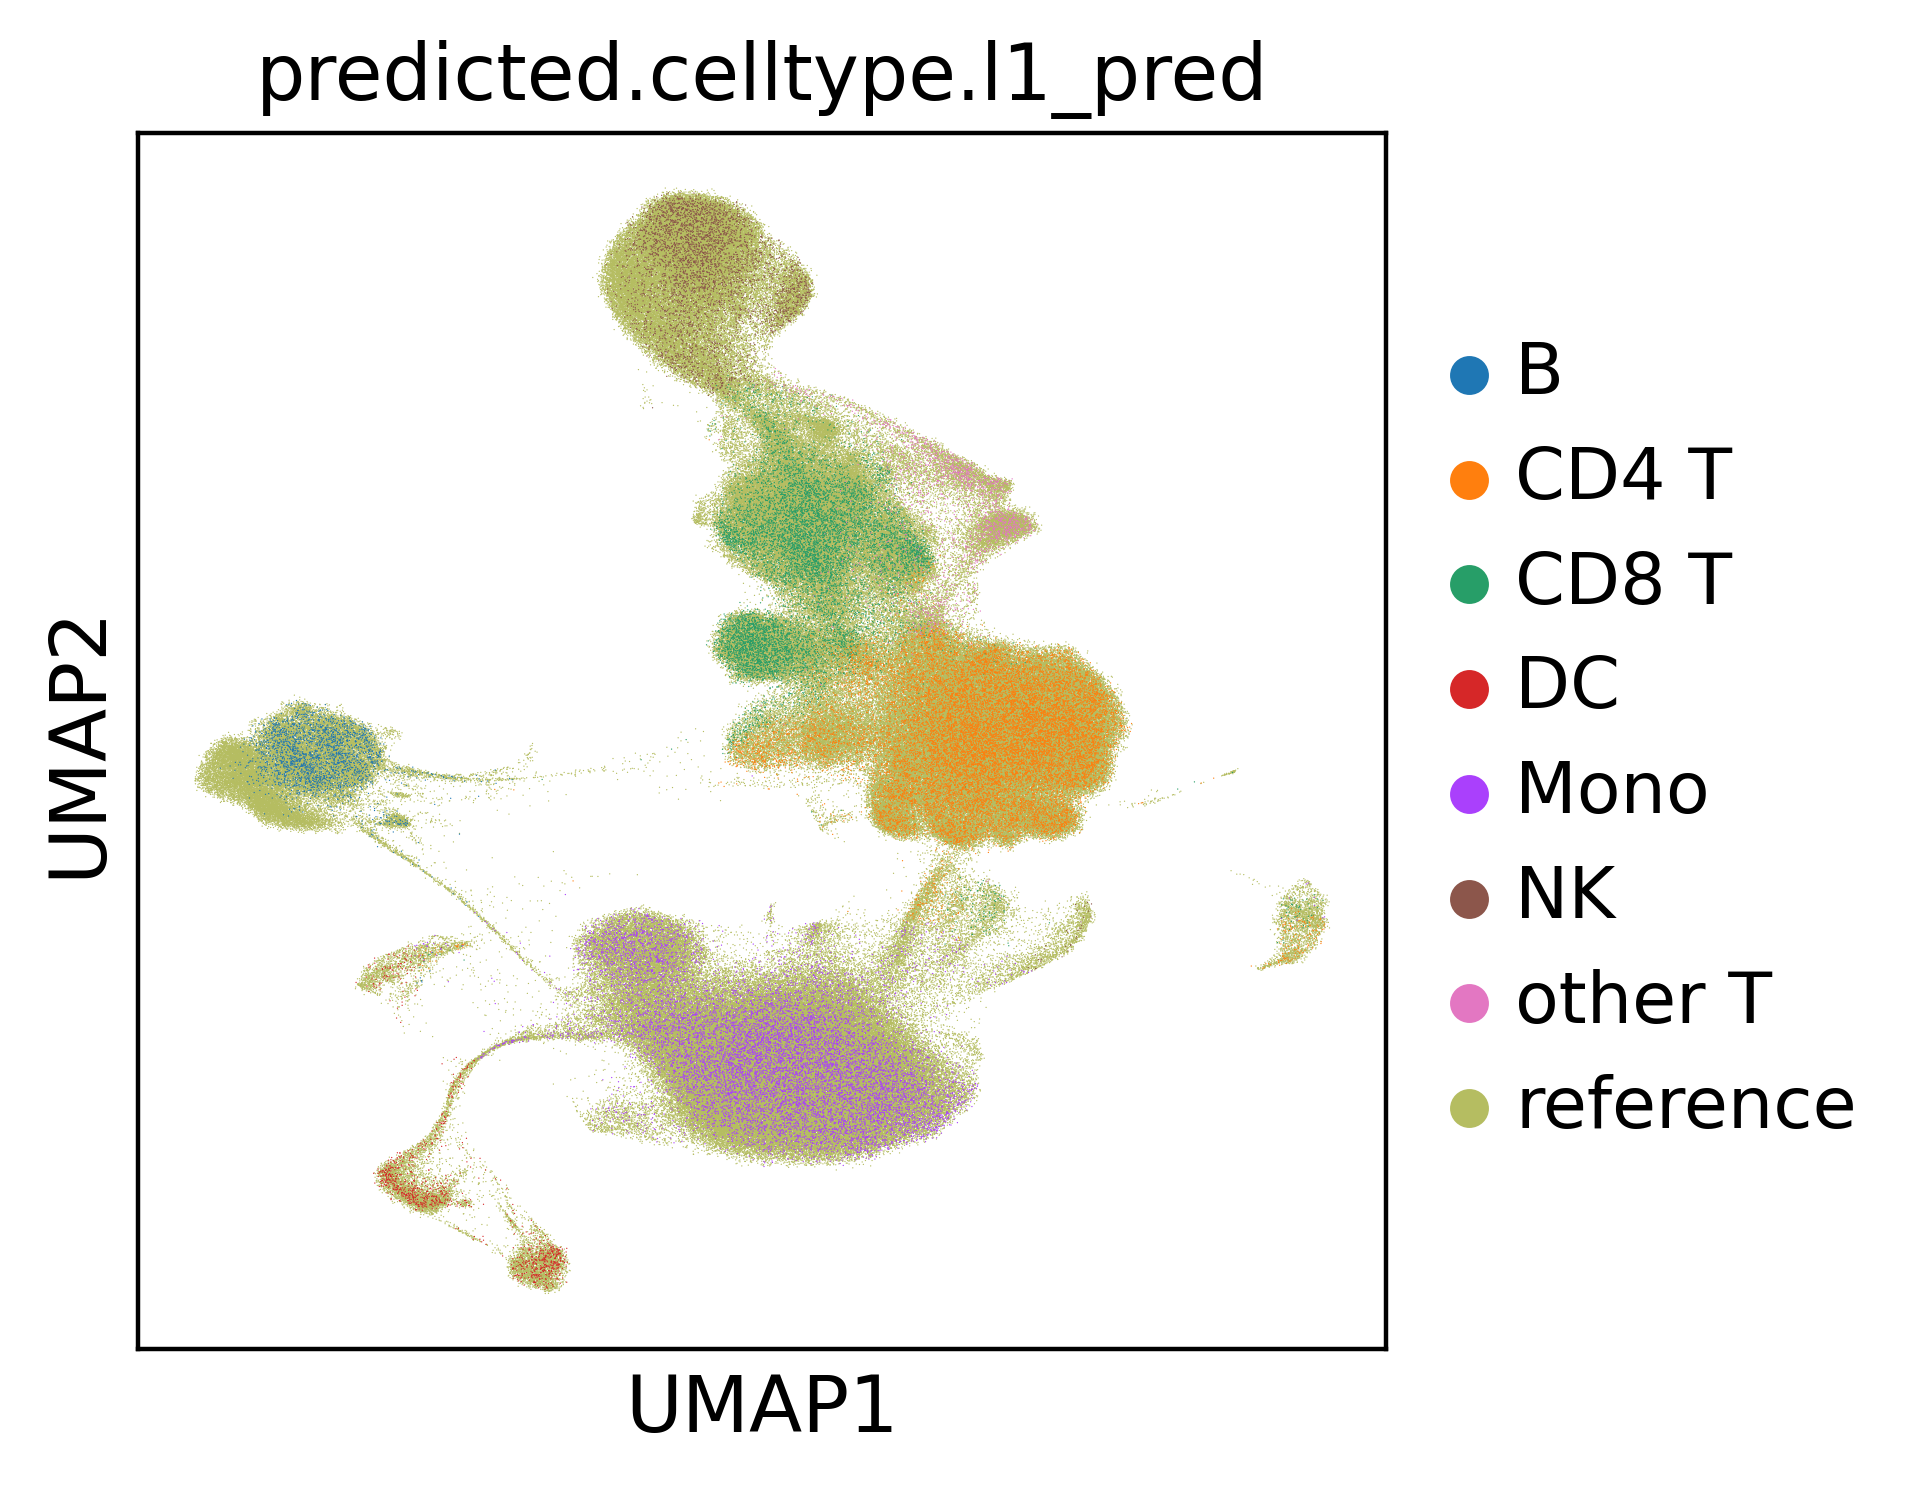

In [88]:
sc.pl.umap(adata_latent_full, color=f'{cell_type_key[0]}_pred')

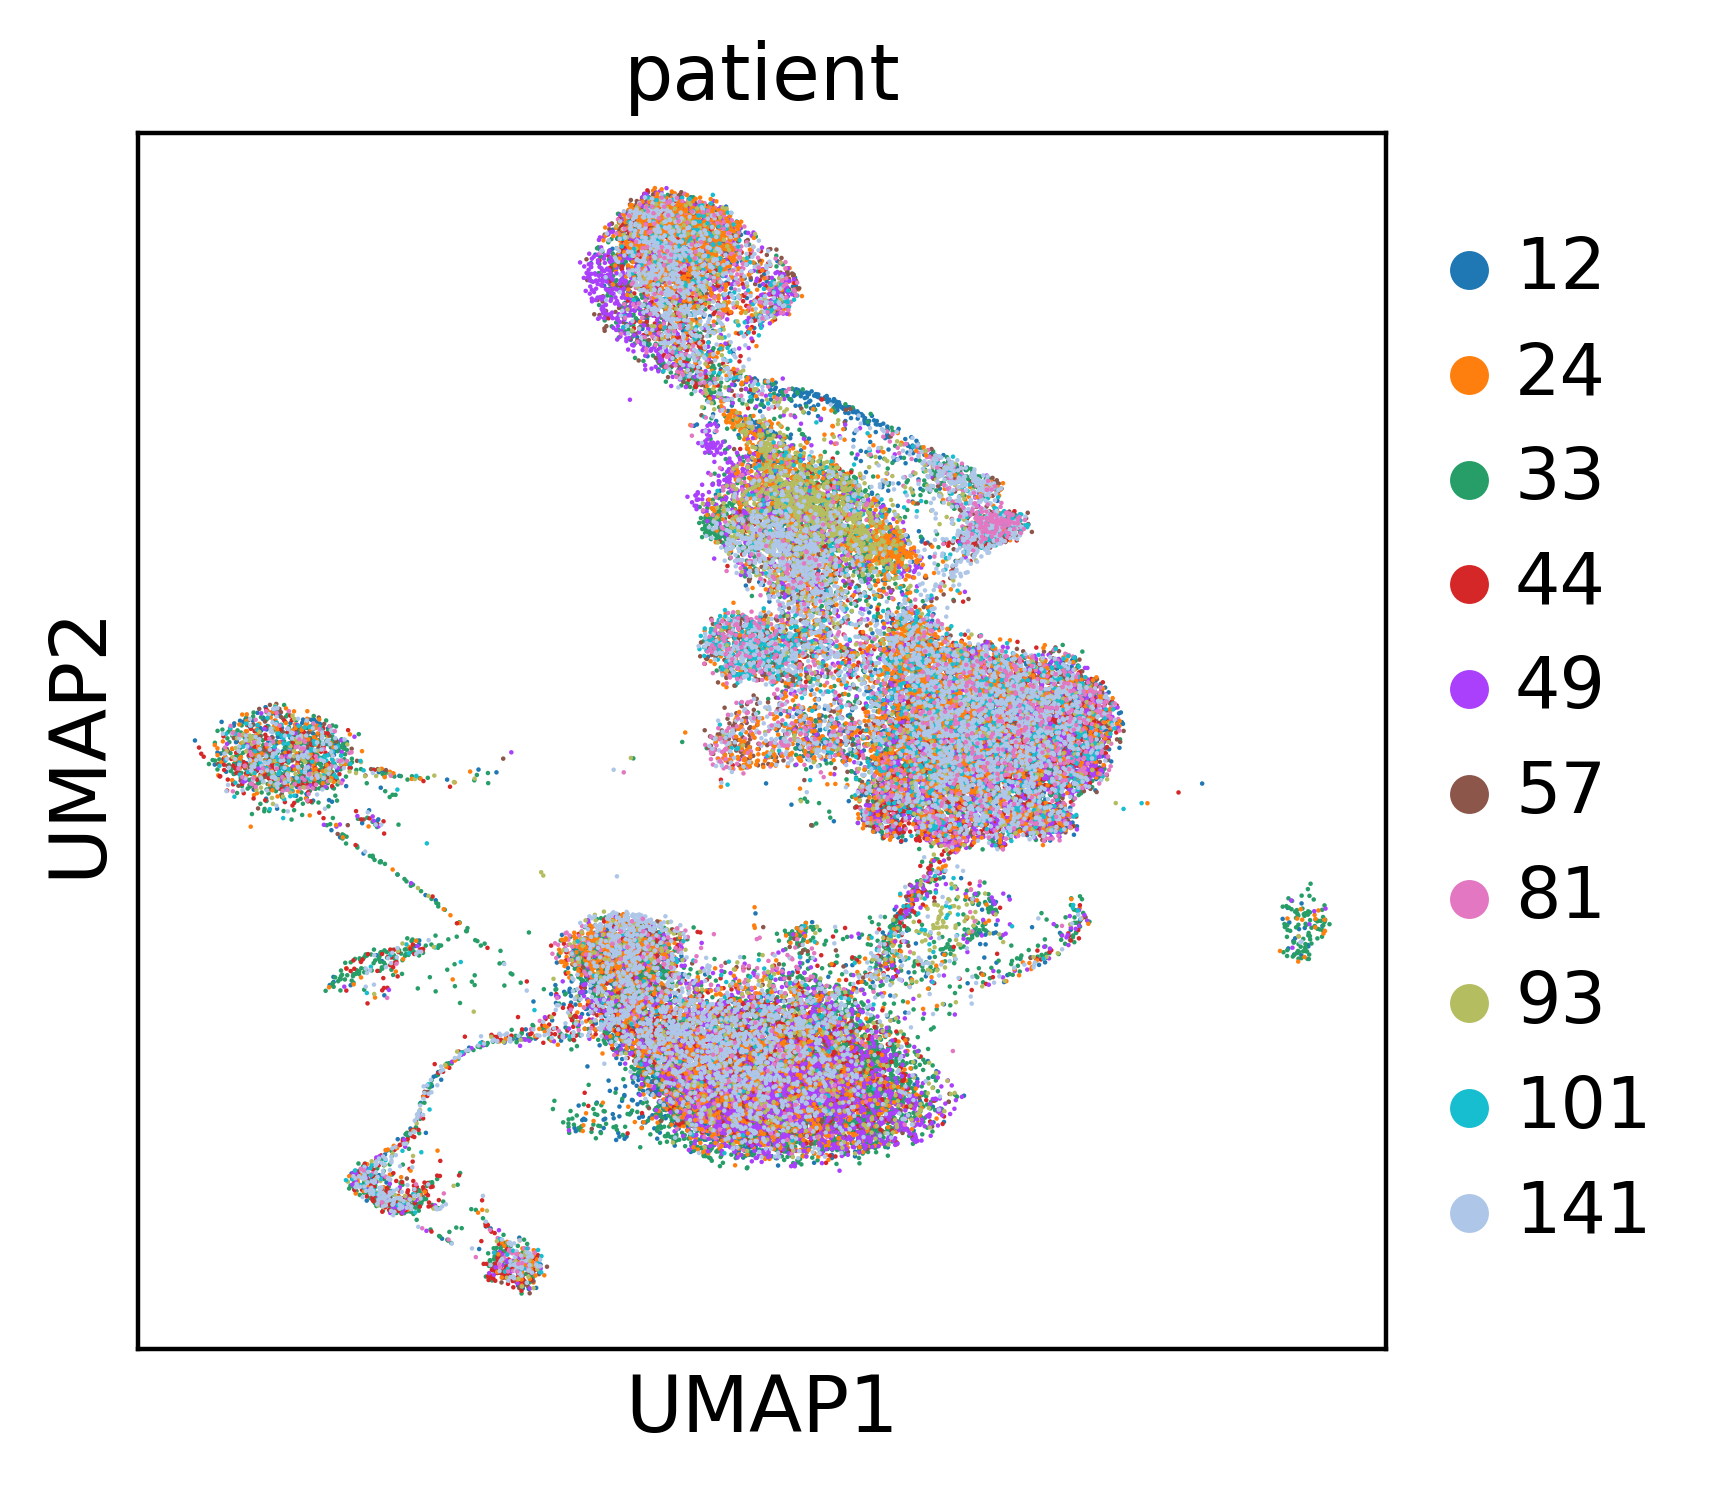

In [89]:
sc.pl.umap(
    adata_latent_full[adata_latent_full.obs.patient.isin(adata_latent_full.obs.patient.sample(10))], 
    color='patient'
)

In [90]:
for col in adata_emb.obs.columns:
    adata_emb.obs[col] = adata_emb.obs[col].astype(str)

In [91]:
adata_emb.write('integrated_final_emb.h5ad')

In [92]:
adata.obs

dataset tissue  \
su_2020_AAACCTGAGATGTAAC-1-1:Mix:Mix_donor1  su_2020  Blood   
su_2020_AAACCTGAGGGCTTGA-1-1:Mix:Mix_donor1  su_2020  Blood   
su_2020_AAACCTGCATGGGACA-1-1:Mix:Mix_donor1  su_2020  Blood   
su_2020_AAACCTGGTAGAGTGC-1-1:Mix:Mix_donor1  su_2020  Blood   
su_2020_AAACCTGTCCCTTGTG-1-1:Mix:Mix_donor1  su_2020  Blood   
...                                              ...    ...   
su_2020_TTTGTCAAGCTGATAA-1-10:J2:111-1       su_2020  Blood   
su_2020_TTTGTCAAGGAGTACC-1-10:J2:111-1       su_2020  Blood   
su_2020_TTTGTCACAACAACCT-1-10:J2:111-1       su_2020  Blood   
su_2020_TTTGTCACACAACGCC-1-10:J2:111-1       su_2020  Blood   
su_2020_TTTGTCACAGTCCTTC-1-10:J2:111-1       su_2020  Blood   

                                                                    sample_type  \
su_2020_AAACCTGAGATGTAAC-1-1:Mix:Mix_donor1  Peripheral Blood Mononuclear Cells   
su_2020_AAACCTGAGGGCTTGA-1-1:Mix:Mix_donor1  Peripheral Blood Mononuclear Cells   
su_2020_AAACCTGCATGGGACA-1-1:Mix:Mix_donor1  Peripheral Blood Mononuclear Cells   
su_2020_AAACCTGGTAGAGTGC-1-1:Mix:Mix_donor1  Peripheral Blood Mononuclear Cells   
su_2020_AAACCTGTCCCTTGTG-1-1:Mix:Mix_donor1  Peripheral Blood Mononuclear Cells   
...                                                                         ...   
su_2020_TTTGTCAAGCTGATAA-1-10:J2:111-1       Peripheral Blood Mononuclear Cells   
su_2020_TTTGTCAAGGAGTACC-1-10:J2:111-1       Peripheral Blood Mononuclear Cells   
su_2020_TTTGTCACAACAACCT-1-10:J2:111-1       Peripheral Blood Mononuclear Cells   
su_2020_TTTGTCACACAACGCC-1-10:J2:111-1       Peripheral Blood Mononuclear Cells   
su_2020_TTTGTCACAGTCCTTC-1-10:J2:111-1       Peripheral Blood Mononuclear Cells   

                                            sample_type_note     patient  \
su_2020_AAACCTGAGATGTAAC-1-1:Mix:Mix_donor1              NaN  Mix_donor1   
su_2020_AAACCTGAGGGCTTGA-1-1:Mix:Mix_donor1              NaN  Mix_donor1   
su_2020_AAACCTGCATGGGACA-1-1:Mix:Mix_donor1              NaN  Mix_donor1   
su_2020_AAACCTGGTAGAGTGC-1-1:Mix:Mix_donor1              NaN  Mix_donor1   
su_2020_AAACCTGTCCCTTGTG-1-1:Mix:Mix_donor1              NaN  Mix_donor1   
...                                                      ...         ...   
su_2020_TTTGTCAAGCTGATAA-1-10:J2:111-1                   NaN         111   
su_2020_TTTGTCAAGGAGTACC-1-10:J2:111-1                   NaN         111   
su_2020_TTTGTCACAACAACCT-1-10:J2:111-1                   NaN         111   
su_2020_TTTGTCACACAACGCC-1-10:J2:111-1                   NaN         111   
su_2020_TTTGTCACAGTCCTTC-1-10:J2:111-1                   NaN         111   

                                                 sample  \
su_2020_AAACCTGAGATGTAAC-1-1:Mix:Mix_donor1  Mix_donor1   
su_2020_AAACCTGAGGGCTTGA-1-1:Mix:Mix_donor1  Mix_donor1   
su_2020_AAACCTGCATGGGACA-1-1:Mix:Mix_donor1  Mix_donor1   
su_2020_AAACCTGGTAGAGTGC-1-1:Mix:Mix_donor1  Mix_donor1   
su_2020_AAACCTGTCCCTTGTG-1-1:Mix:Mix_donor1  Mix_donor1   
...                                                 ...   
su_2020_TTTGTCAAGCTGATAA-1-10:J2:111-1            111-1   
su_2020_TTTGTCAAGGAGTACC-1-10:J2:111-1            111-1   
su_2020_TTTGTCACAACAACCT-1-10:J2:111-1            111-1   
su_2020_TTTGTCACACAACGCC-1-10:J2:111-1            111-1   
su_2020_TTTGTCACAGTCCTTC-1-10:J2:111-1            111-1   

                                                                         race_reported  \
su_2020_AAACCTGAGATGTAAC-1-1:Mix:Mix_donor1                                        NaN   
su_2020_AAACCTGAGGGCTTGA-1-1:Mix:Mix_donor1                                        NaN   
su_2020_AAACCTGCATGGGACA-1-1:Mix:Mix_donor1                                        NaN   
su_2020_AAACCTGGTAGAGTGC-1-1:Mix:Mix_donor1                                        NaN   
su_2020_AAACCTGTCCCTTGTG-1-1:Mix:Mix_donor1                                        NaN   
...                                                                                ...   
su_2020_TTTGTCAAGCTGATAA-1-10:J2:111-1 